# IMA206-projet: Self-supervised learning for medical image classification

# SimCLR:

## To do for next week-0614:
- 用test dataset做最后的结果比较 （Validation dataset 训练时可以按paper里用上early-stopping）
- 图片导入： 用64*64 （以匹配ResNet18）
- Linear probing (using pytorch，不要用sklearn)
- 借助Visualization (Pretrain部分的t-SNE和Fine tuning的Confusion Matrix) 分析结果和数据情况

---

In [ ]:
# pip install medmnist

In [1]:
import medmnist
from medmnist import INFO
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random

In [2]:
# Load the dataset
data_flag = 'pathmnist'
download = True

# Get dataset information
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

class Rotate90orMinus90:
    def __call__(self, x):
        if random.random() > 0.5:
            return transforms.functional.rotate(x, 90)
        else:
            return transforms.functional.rotate(x, -90)


PathMNIST_MEAN = [0.73765225, 0.53090023, 0.70307171]
PathMNIST_STD = [0.12319908, 0.17607205, 0.12394462]


# Define transformations for data augmentation
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),  # random resized crop  # 64
    transforms.RandomHorizontalFlip(p=0.5),  # random horizontal flip
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),  # random gaussian blur, changed kernel_size from 23 to 7
    Rotate90orMinus90(),  # random rotate 90 or -90
    transforms.ToTensor(),  # to tensor
    transforms.Normalize(mean=PathMNIST_MEAN, std=PathMNIST_STD) # normalize
])


org_data_transform = transforms.Compose([
    transforms.ToTensor(),  # to tensor
    transforms.Normalize(mean=[.5], std=[.5]) # normalize
])


In [3]:
org_train_dataset = DataClass(split='train', transform= org_data_transform , download=download)
aug_train_dataset = DataClass(split='train', transform=data_transform, download=download)

Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist.npz


In [4]:
from torch.utils.data import Dataset

class PairedDataset(Dataset):
    def __init__(self, org_dataset, aug_dataset):
        self.org_dataset = org_dataset
        self.aug_dataset = aug_dataset
        assert len(org_dataset) == len(aug_dataset), "Datasets must be of the same length"

    def __len__(self):
        return len(self.org_dataset)

    def __getitem__(self, idx):
        org_image, _ = self.org_dataset[idx]
        aug_image, _ = self.aug_dataset[idx]
        return org_image, aug_image


paired_dataset = PairedDataset(org_train_dataset, aug_train_dataset)
train_loader = DataLoader(paired_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

In [5]:

org_val_dataset = DataClass(split='val', transform=org_data_transform, download=download)
aug_val_dataset = DataClass(split='val', transform=data_transform, download=download)

val_paired_dataset = PairedDataset(org_val_dataset, aug_val_dataset)

val_loader = DataLoader(dataset=org_val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist.npz


In [6]:
# Define the SimCLR model
class SimCLR(nn.Module):
    def __init__(self, base_model, out_dim):
        super(SimCLR, self).__init__()
        self.encoder = self.get_resnet(base_model)
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def get_resnet(self, base_model):
        model = models.__dict__[base_model](pretrained=False)
        model = nn.Sequential(*list(model.children())[:-1])
        return model

    def forward(self, x):
        h = self.encoder(x)
        h = h.squeeze()
        z = self.projector(h)
        return h, z

model = SimCLR(base_model='resnet18', out_dim=128).cuda()   # output dimension = 128

# Define the NT-Xent Loss function
class NT_XentLoss(nn.Module):
    def __init__(self, temperature):
        super(NT_XentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        mask = self.mask_correlated_samples(batch_size)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        positives = torch.cat([sim_i_j, sim_j_i], dim=0)
        negatives = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positives.device).long()
        logits = torch.cat((positives.unsqueeze(1), negatives), dim=1)
        loss = self.criterion(logits, labels)
        # print(labels)
        return loss / N

criterion = NT_XentLoss(temperature=0.5).cuda()   # temperature

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
num_epochs = 50

def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (org_images,aug_images) in enumerate(train_loader):
            org_images = org_images.cuda()
            aug_images = aug_images.cuda()
            
            z_i = model(org_images)
            z_j = model(aug_images)
            
            if isinstance(z_i, tuple):
                z_i = z_i[0]
            if isinstance(z_j, tuple):
                z_j = z_j[0]
            
            loss = criterion(z_i, z_j)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(train_loader)

In [8]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    print(f'Epoch {epoch}, Train Loss: {train_loss}')

# Save features for evaluation
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h, _ = model(data)
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

save_features(model, val_loader, 'pathmnist_features_ep_50.npz')

Epoch 0, Batch 0, Loss: 6.101565361022949


Epoch 0, Batch 10, Loss: 5.175788879394531
Epoch 0, Batch 20, Loss: 5.021904468536377
Epoch 0, Batch 30, Loss: 4.916759967803955
Epoch 0, Batch 40, Loss: 4.834035396575928
Epoch 0, Batch 50, Loss: 4.788441181182861
Epoch 0, Batch 60, Loss: 4.726047992706299
Epoch 0, Batch 70, Loss: 4.692691802978516
Epoch 0, Batch 80, Loss: 4.6641316413879395
Epoch 0, Batch 90, Loss: 4.631612777709961
Epoch 0, Batch 100, Loss: 4.61738395690918
Epoch 0, Batch 110, Loss: 4.594862461090088
Epoch 0, Batch 120, Loss: 4.623063087463379
Epoch 0, Batch 130, Loss: 4.568181991577148
Epoch 0, Batch 140, Loss: 4.560776233673096
Epoch 0, Batch 150, Loss: 4.602596759796143
Epoch 0, Batch 160, Loss: 4.596433639526367
Epoch 0, Batch 170, Loss: 4.580502510070801
Epoch 0, Batch 180, Loss: 4.547799110412598
Epoch 0, Batch 190, Loss: 4.560157299041748
Epoch 0, Batch 200, Loss: 4.546992778778076
Epoch 0, Batch 210, Loss: 4.543426036834717
Epoch 0, Batch 220, Loss: 4.51479434967041
Epoch 0, Batch 230, Loss: 4.53407001495361

## Display of visualization:

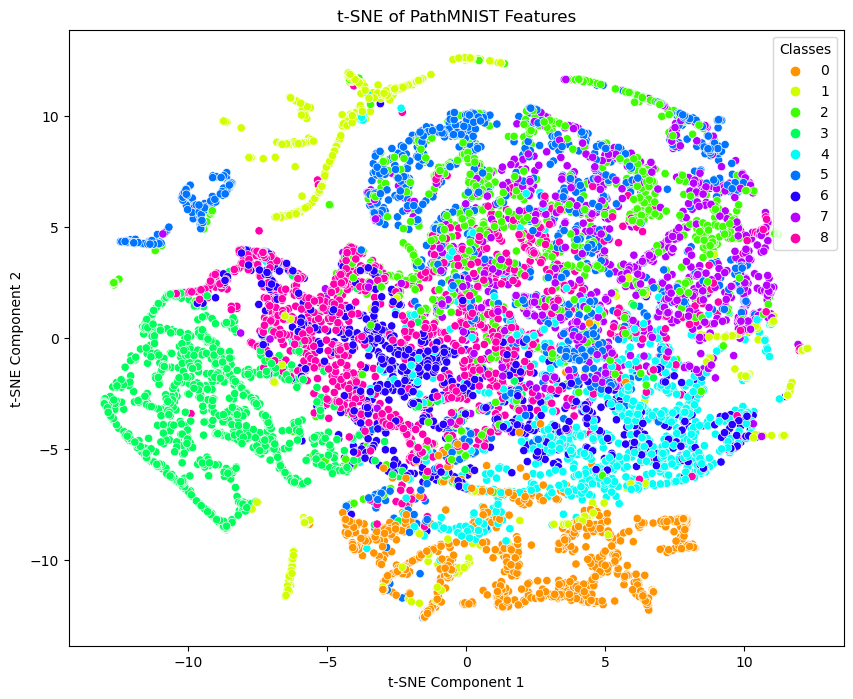

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

# Load features
data = np.load('pathmnist_features_ep_50.npz')
features = data['features']
labels = data['labels']

# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_2d = tsne.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the t-SNE results and labels
df = pd.DataFrame({
    'TSNE1': features_2d[:, 0],
    'TSNE2': features_2d[:, 1],
    'Label': labels
})

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Label', legend='full', palette=palette)
plt.title('t-SNE of PathMNIST Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


### Validation:

In [9]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Load features
data = np.load('pathmnist_features_ep_50.npz')
features = data['features']
labels = data['labels']

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train logistic regression classifier
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

# Predict on validation set
y_pred = classifier.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

# Save the model parameters
torch.save(model.state_dict(), 'simclr_model.pth')

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation Accuracy: 0.5912


### Fine-Tuning:

#### We use 1% of the training data for fine-tuning

In [8]:
def get_sub_indices(dataset, proportion=0.01):
    class_indices = {}
    
    for i, data in enumerate(dataset): 
        class_idx = int(data[1][0])
        if class_idx not in class_indices:
            class_indices[class_idx] = []
        class_indices[class_idx].append(i)
    
    # List to store subset indices
    subset_indices = []
        
    # Choose proportionate indices from each class
    for indices in class_indices.values():
        selected_indices = np.random.choice(
            indices, 
            size=int(np.ceil(len(indices) * proportion)),
            replace=False
        ).tolist()  # Ensure indices are in a list format
        subset_indices.extend(selected_indices)

    return subset_indices

In [9]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 1% of training data for fine-tuning
num_samples = len(org_train_dataset)
indices = list(range(num_samples))
np.random.seed(42)
fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.01)

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)

# Fine-tune the model
fine_tune_epochs = 50
for epoch in range(fine_tune_epochs):
    fine_tune_loss = fine_tune(fine_tune_model, fine_tune_loader, criterion_fine_tune, optimizer_fine_tune, epoch)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {fine_tune_loss}')

Fine-tune Epoch 0, Batch 0, Loss: 2.423241138458252
Fine-tune Epoch 0, Train Loss: 2.32806932926178
Fine-tune Epoch 1, Batch 0, Loss: 2.178252696990967
Fine-tune Epoch 1, Train Loss: 2.3667450547218323
Fine-tune Epoch 2, Batch 0, Loss: 2.3512232303619385
Fine-tune Epoch 2, Train Loss: 2.306971311569214
Fine-tune Epoch 3, Batch 0, Loss: 2.1549408435821533
Fine-tune Epoch 3, Train Loss: 2.2436360120773315
Fine-tune Epoch 4, Batch 0, Loss: 2.276399850845337
Fine-tune Epoch 4, Train Loss: 2.2349902391433716
Fine-tune Epoch 5, Batch 0, Loss: 2.2219390869140625
Fine-tune Epoch 5, Train Loss: 2.1592199206352234
Fine-tune Epoch 6, Batch 0, Loss: 2.1790738105773926
Fine-tune Epoch 6, Train Loss: 2.1246694922447205
Fine-tune Epoch 7, Batch 0, Loss: 2.0550737380981445
Fine-tune Epoch 7, Train Loss: 2.064580798149109
Fine-tune Epoch 8, Batch 0, Loss: 2.0907905101776123
Fine-tune Epoch 8, Train Loss: 2.0392228960990906
Fine-tune Epoch 9, Batch 0, Loss: 2.047835350036621
Fine-tune Epoch 9, Train Los

- Validation and see the accuracy result:

In [10]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned-1.npz')

# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned-1.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fine-tuned Validation Accuracy: 0.6997


### Confusion Matrix:


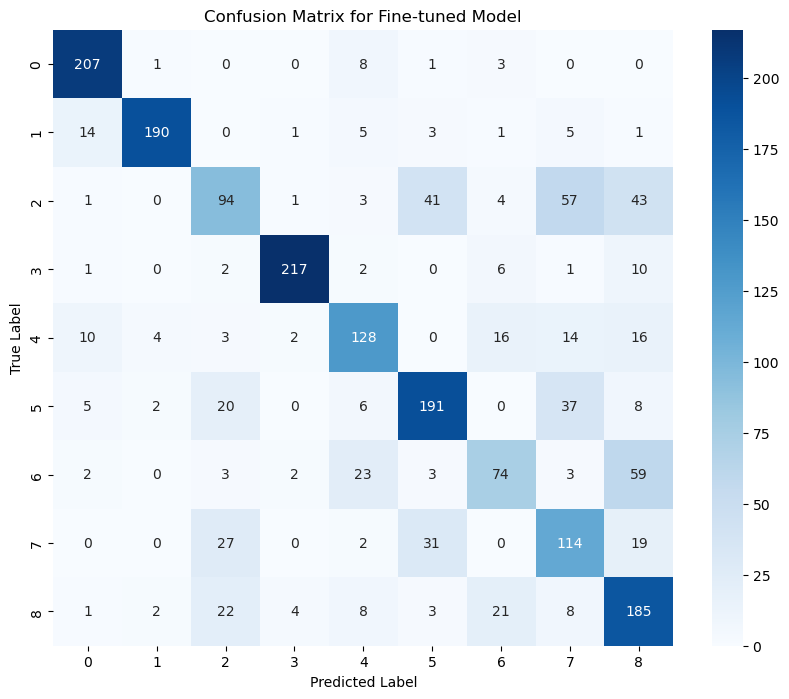

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_val_fine_tuned, y_pred_fine_tuned)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels_fine_tuned), yticklabels=np.unique(labels_fine_tuned))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fine-tuned Model')
plt.show()

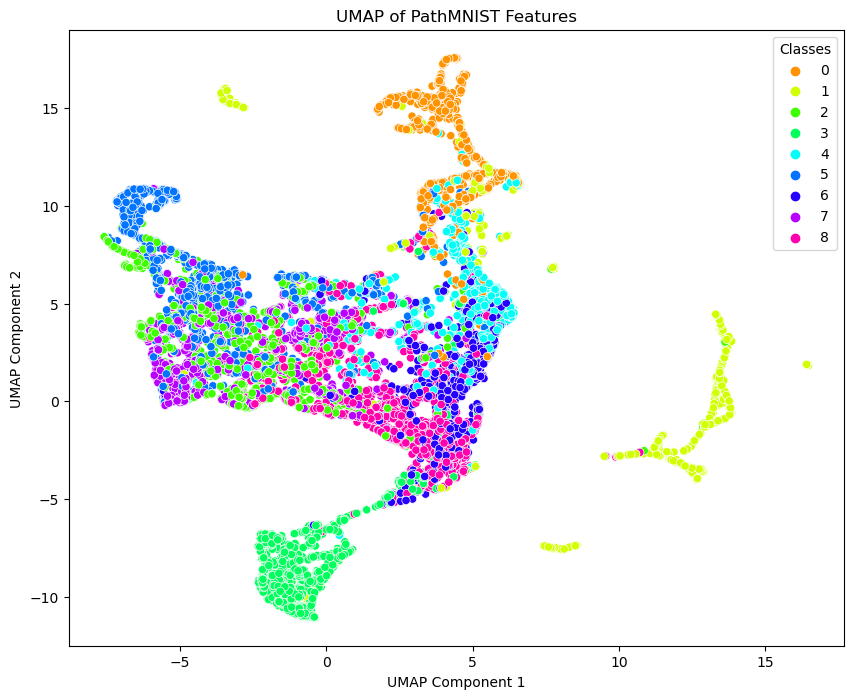

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap.umap_ as umap

data = np.load('pathmnist_features_fine_tuned-1.npz')
features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()


#### We use 10% of the training data for fine-tuning

In [12]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 10% of training data for fine-tuning
np.random.seed(42)
fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.1)

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)

# Fine-tune the model
fine_tune_epochs = 50
for epoch in range(fine_tune_epochs):
    fine_tune_loss = fine_tune(fine_tune_model, fine_tune_loader, criterion_fine_tune, optimizer_fine_tune, epoch)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {fine_tune_loss}')



/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.254918098449707
Fine-tune Epoch 0, Batch 10, Loss: 2.1871731281280518
Fine-tune Epoch 0, Batch 20, Loss: 2.1053740978240967
Fine-tune Epoch 0, Batch 30, Loss: 2.019759178161621
Fine-tune Epoch 0, Train Loss: 2.132733725839191
Fine-tune Epoch 1, Batch 0, Loss: 2.01231050491333
Fine-tune Epoch 1, Batch 10, Loss: 2.0625698566436768
Fine-tune Epoch 1, Batch 20, Loss: 1.9862542152404785
Fine-tune Epoch 1, Batch 30, Loss: 1.803222417831421
Fine-tune Epoch 1, Train Loss: 1.9464648995134566
Fine-tune Epoch 2, Batch 0, Loss: 1.7756236791610718
Fine-tune Epoch 2, Batch 10, Loss: 1.6410417556762695
Fine-tune Epoch 2, Batch 20, Loss: 1.33145010471344
Fine-tune Epoch 2, Batch 30, Loss: 1.2369452714920044
Fine-tune Epoch 2, Train Loss: 1.4410636921723683
Fine-tune Epoch 3, Batch 0, Loss: 1.002636432647705
Fine-tune Epoch 3, Batch 10, Loss: 0.8733015656471252
Fine-tune Epoch 3, Batch 20, Loss: 0.9388752579689026
Fine-tune Epoch 3, Batch 30, Loss: 0.8522278070449829

In [13]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned.npz')

# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fine-tuned Validation Accuracy: 0.8466


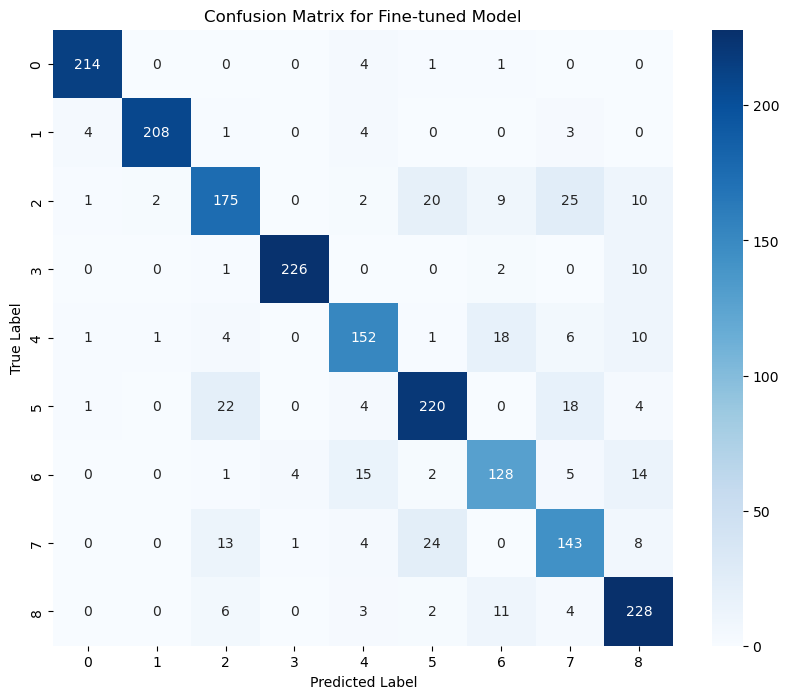

In [14]:
# Calculate confusion matrix
cm = confusion_matrix(y_val_fine_tuned, y_pred_fine_tuned)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels_fine_tuned), yticklabels=np.unique(labels_fine_tuned))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fine-tuned Model')
plt.show()

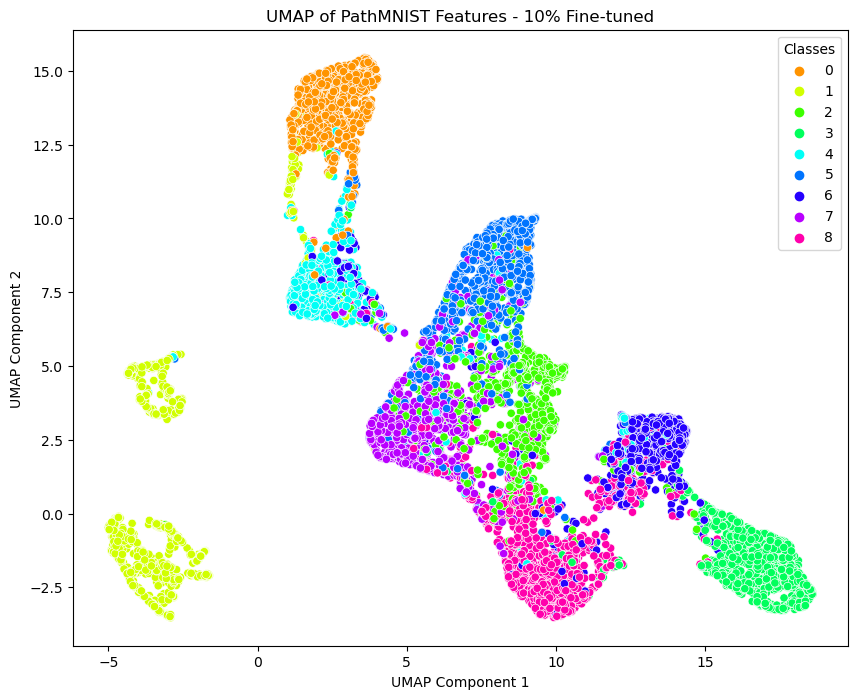

In [23]:
data = np.load('pathmnist_features_fine_tuned.npz')
features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features - 10% Fine-tuned')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()


---

#### We extract 100% of training data for fine-tuning

In [16]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 100% of training data for fine-tuning

# np.random.seed(42)
# fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.1)

num_samples = len(org_train_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
fine_tune_size = int(num_samples)
fine_tune_indices = indices[:fine_tune_size]

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)

# Fine-tune the model
fine_tune_epochs = 50
for epoch in range(fine_tune_epochs):
    fine_tune_loss = fine_tune(fine_tune_model, fine_tune_loader, criterion_fine_tune, optimizer_fine_tune, epoch)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {fine_tune_loss}')



/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.2949326038360596
Fine-tune Epoch 0, Batch 10, Loss: 2.1999006271362305
Fine-tune Epoch 0, Batch 20, Loss: 2.106029987335205
Fine-tune Epoch 0, Batch 30, Loss: 2.096123218536377
Fine-tune Epoch 0, Batch 40, Loss: 1.9630627632141113
Fine-tune Epoch 0, Batch 50, Loss: 1.9457201957702637
Fine-tune Epoch 0, Batch 60, Loss: 1.7762492895126343
Fine-tune Epoch 0, Batch 70, Loss: 1.6542764902114868
Fine-tune Epoch 0, Batch 80, Loss: 1.359886646270752
Fine-tune Epoch 0, Batch 90, Loss: 1.2178841829299927
Fine-tune Epoch 0, Batch 100, Loss: 1.1120346784591675
Fine-tune Epoch 0, Batch 110, Loss: 0.932527482509613
Fine-tune Epoch 0, Batch 120, Loss: 0.8490159511566162
Fine-tune Epoch 0, Batch 130, Loss: 0.7929060459136963
Fine-tune Epoch 0, Batch 140, Loss: 0.9052292108535767
Fine-tune Epoch 0, Batch 150, Loss: 0.8133283853530884
Fine-tune Epoch 0, Batch 160, Loss: 0.8129669427871704
Fine-tune Epoch 0, Batch 170, Loss: 0.7367739081382751
Fine-tune Epoch 0, Batch 

In [17]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned_100.npz')

# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned_100.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fine-tuned Validation Accuracy: 0.9365


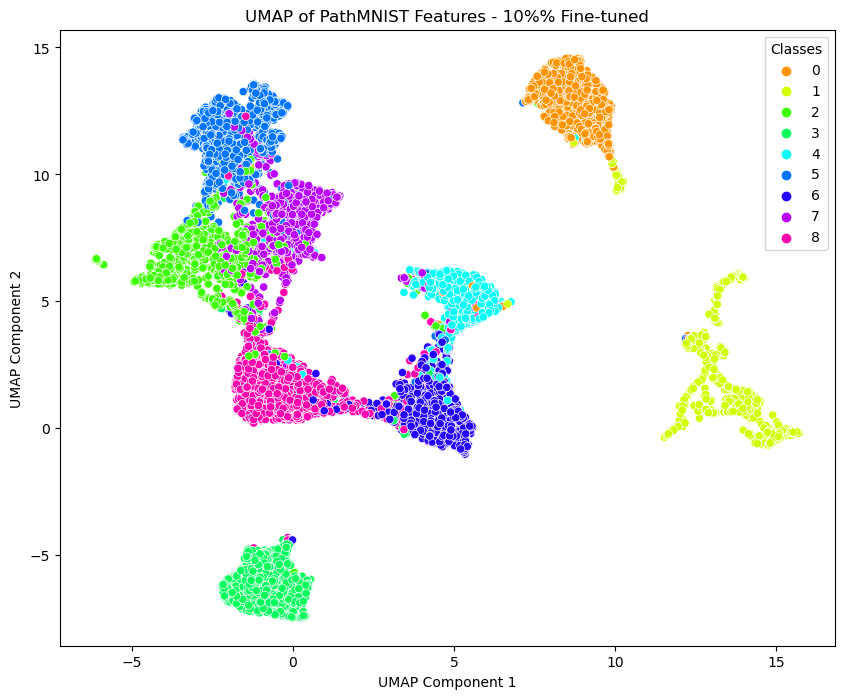

In [50]:
data = np.load('pathmnist_features_fine_tuned_100.npz')
features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features - 100% Fine-tuned')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()


------

## Random Drafts

In [13]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode

class_indices = {}

# Extract 1% of training data for fine-tuning
num_samples = len(org_train_dataset)

for i, data in enumerate(org_train_dataset): 
    class_idx = int(data[1][0])
    if class_idx not in class_indices:
        class_indices[class_idx] = []
    class_indices[class_idx].append(i)

# print(class_indices)

{0: [0, 33, 37, 47, 50, 52, 63, 64, 74, 85, 90, 91, 98, 127, 129, 150, 169, 170, 173, 193, 218, 220, 230, 231, 242, 244, 246, 258, 279, 289, 291, 296, 301, 322, 326, 347, 349, 357, 361, 368, 371, 395, 396, 401, 409, 414, 417, 436, 467, 473, 485, 486, 488, 493, 497, 500, 501, 502, 510, 513, 519, 531, 549, 567, 573, 584, 595, 606, 618, 636, 637, 638, 646, 658, 664, 680, 699, 703, 726, 733, 734, 771, 773, 776, 778, 779, 795, 814, 817, 825, 837, 848, 863, 869, 874, 876, 883, 887, 889, 913, 914, 936, 939, 968, 974, 982, 1013, 1028, 1037, 1040, 1045, 1056, 1059, 1063, 1083, 1100, 1126, 1163, 1169, 1172, 1191, 1232, 1242, 1250, 1253, 1269, 1274, 1275, 1278, 1296, 1303, 1305, 1322, 1323, 1325, 1329, 1342, 1345, 1353, 1357, 1362, 1364, 1373, 1379, 1380, 1381, 1392, 1422, 1426, 1444, 1449, 1452, 1460, 1465, 1470, 1474, 1475, 1482, 1485, 1491, 1492, 1499, 1506, 1513, 1536, 1554, 1594, 1595, 1598, 1607, 1622, 1646, 1654, 1669, 1680, 1690, 1698, 1702, 1704, 1708, 1712, 1749, 1756, 1804, 1818, 1819,

In [23]:
def get_sub_indices(dataset, proportion=0.01):
    class_indices = {}
    
    for i, data in enumerate(dataset): 
        class_idx = int(data[1][0])
        if class_idx not in class_indices:
            class_indices[class_idx] = []
        class_indices[class_idx].append(i)
    
    # List to store subset indices
    subset_indices = []
        
    # Choose proportionate indices from each class
    for indices in class_indices.values():
        selected_indices = np.random.choice(
            indices, 
            size=int(np.ceil(len(indices) * proportion)),
            replace=False
        ).tolist()  # Ensure indices are in a list format
        subset_indices.extend(selected_indices)

    return subset_indices
        

In [26]:
np.random.seed(42)
fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.1)
print(fine_tune_indices)
print(len(fine_tune_indices))

[1305, 74646, 45458, 67049, 57866, 50466, 15601, 34493, 24739, 16187, 81864, 4039, 38984, 7583, 2570, 82861, 3204, 9896, 5446, 30563, 80519, 39167, 62020, 34824, 19557, 86934, 33562, 37841, 36874, 15150, 68264, 11490, 84539, 39508, 62751, 48813, 38200, 32143, 87657, 55377, 88859, 83199, 69062, 23091, 38357, 87047, 39501, 25527, 59405, 81798, 36824, 62031, 3181, 80159, 5723, 29131, 36462, 23595, 62138, 32093, 89215, 57873, 79831, 65133, 14622, 47531, 54137, 33464, 36589, 61187, 14025, 7421, 20931, 66724, 28426, 37740, 29144, 79956, 7425, 87125, 47860, 68909, 40349, 4409, 24212, 50142, 15855, 18381, 66440, 14915, 33358, 84582, 43487, 24596, 20106, 2581, 87607, 61562, 40507, 63244, 86382, 63570, 47008, 77884, 72649, 83103, 73818, 28672, 73436, 38794, 78390, 11259, 52380, 22130, 33424, 9295, 42362, 9666, 7316, 78982, 45036, 45611, 37020, 17378, 58416, 26159, 21993, 75497, 39964, 21301, 16276, 70755, 56573, 3150, 79318, 28903, 50549, 20201, 24274, 44179, 34163, 68634, 13183, 77376, 485, 750

In [27]:
proportion = 0.1

In [28]:
# List to store subset indices
subset_indices = []

np.random.seed(42)

# Choose proportionate indices from each class
for indices in class_indices.values():
    selected_indices = np.random.choice(
        indices, 
        size=int(np.ceil(len(indices) * proportion)),
        replace=False
    ).tolist()  # Ensure indices are in a list format
    subset_indices.extend(selected_indices)

print(subset_indices)

[1305, 74646, 45458, 67049, 57866, 50466, 15601, 34493, 24739, 16187, 81864, 4039, 38984, 7583, 2570, 82861, 3204, 9896, 5446, 30563, 80519, 39167, 62020, 34824, 19557, 86934, 33562, 37841, 36874, 15150, 68264, 11490, 84539, 39508, 62751, 48813, 38200, 32143, 87657, 55377, 88859, 83199, 69062, 23091, 38357, 87047, 39501, 25527, 59405, 81798, 36824, 62031, 3181, 80159, 5723, 29131, 36462, 23595, 62138, 32093, 89215, 57873, 79831, 65133, 14622, 47531, 54137, 33464, 36589, 61187, 14025, 7421, 20931, 66724, 28426, 37740, 29144, 79956, 7425, 87125, 47860, 68909, 40349, 4409, 24212, 50142, 15855, 18381, 66440, 14915, 33358, 84582, 43487, 24596, 20106, 2581, 87607, 61562, 40507, 63244, 86382, 63570, 47008, 77884, 72649, 83103, 73818, 28672, 73436, 38794, 78390, 11259, 52380, 22130, 33424, 9295, 42362, 9666, 7316, 78982, 45036, 45611, 37020, 17378, 58416, 26159, 21993, 75497, 39964, 21301, 16276, 70755, 56573, 3150, 79318, 28903, 50549, 20201, 24274, 44179, 34163, 68634, 13183, 77376, 485, 750

In [29]:
len(subset_indices)

9004

In [21]:
len(org_train_dataset)

89996

In [8]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 1% of training data for fine-tuning
num_samples = len(org_train_dataset)

indices = list(range(num_samples))
np.random.shuffle(indices)
fine_tune_size = int(num_samples * 0.01)
fine_tune_indices = indices[:fine_tune_size]

print(fine_tune_indices)

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[28884, 60973, 33594, 7563, 33192, 80622, 37592, 27704, 16216, 48932, 38129, 18966, 88885, 12479, 82607, 26614, 16367, 69996, 17788, 1898, 34640, 78116, 12576, 87249, 65189, 86386, 57386, 43811, 11869, 29839, 23009, 17143, 67959, 80483, 12761, 68843, 27700, 17170, 5811, 32576, 33255, 23555, 17648, 80829, 21000, 7453, 47397, 64306, 52868, 524, 59122, 38497, 47059, 63054, 68621, 27393, 35332, 51184, 14973, 7768, 30840, 23217, 13750, 16552, 20042, 79215, 26971, 77008, 40869, 44527, 74539, 4706, 14383, 37196, 71469, 10202, 16615, 35621, 134, 84691, 35774, 24827, 82448, 78179, 45921, 18629, 70867, 19379, 16103, 30202, 7076, 69442, 42860, 64353, 82877, 62438, 23770, 33988, 53047, 89394, 74369, 29227, 18728, 70210, 14945, 86474, 703, 78352, 29221, 32567, 4059, 69883, 57721, 55038, 76410, 41241, 46288, 67567, 21495, 44876, 88766, 72533, 33929, 38429, 38026, 4255, 33270, 33607, 42371, 26546, 41595, 48666, 61488, 44671, 69771, 65864, 83330, 39289, 13634, 87615, 54971, 73227, 68152, 62198, 60863,